In [2]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import reverse_geocoder as rg
import seaborn as sns
import squarify    
from geopy.distance import great_circle

In [39]:
# Data from https://sites.google.com/site/yangdingqi/home/foursquare-dataset

In [28]:
df_poi = pd.read_csv("raw_POIs_US.txt")
df_poi.lat = df_poi.lat.astype(np.float32)
df_poi.lon = df_poi.lon.astype(np.float32)

In [34]:
df_check = pd.read_pickle("df_check.pickle")
df_check["hour"] = df_check.local_time.apply(lambda x: x.strftime("%H"))

def part_hour(x):
    h, m = x.strftime("%H:%M").split(":")
    h, m = int(h), int(m)
    return h+m/60

df_check["hour_min"] = df_check.local_time.apply(lambda x: part_hour(x))
df_check["dow"] = df_check.local_time.apply(lambda x: x.strftime("%a"))
df_check["weekend"] = df_check.dow.apply(lambda x: 1 if (x=="Sun" or x=="Sat") else 0)

In [29]:
df_poi.head()

,poi_id,lat,lon,category,country
0,3fd66200f964a52000e61ee3,40.729210,-73.998756,Post Office,US
1,3fd66200f964a52000e71ee3,40.733597,-74.003136,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975731,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003754,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345905,-71.086998,Indian Restaurant,US


In [6]:
vals = df_poi[["lat", "lon"]].values.tolist()
coordinates = tuple([tuple(x) for x in vals])

In [7]:
%%time
results = rg.search(coordinates)
cities = [x["name"] for x in results]
admin1 = [x["admin1"] for x in results]

df_poi["city"] = cities
df_poi["admin1"] = admin1

Loading formatted geocoded file...
CPU times: user 2.91 s, sys: 280 ms, total: 3.19 s
Wall time: 2.41 s


In [8]:
df = df_check.merge(df_poi, how='inner', on="poi_id")
df.head()

,user_id,poi_id,time_utc,time_offset,local_time,hour,dow,weekend,lat,lon,category,country,city,admin1
0,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300,2012-04-03 13:00:08+00:00,13,Tue,0,30.270786,-97.753151,Office,US,Austin,Texas
1,208842,4b4606f2f964a520751426e3,Wed Apr 04 19:20:35 +0000 2012,-300,2012-04-04 14:20:35+00:00,14,Wed,0,30.270786,-97.753151,Office,US,Austin,Texas
2,208842,4b4606f2f964a520751426e3,Mon Apr 09 13:57:42 +0000 2012,-300,2012-04-09 08:57:42+00:00,08,Mon,0,30.270786,-97.753151,Office,US,Austin,Texas
3,208842,4b4606f2f964a520751426e3,Thu Apr 12 13:27:53 +0000 2012,-300,2012-04-12 08:27:53+00:00,08,Thu,0,30.270786,-97.753151,Office,US,Austin,Texas
4,208842,4b4606f2f964a520751426e3,Fri Apr 13 15:41:49 +0000 2012,-300,2012-04-13 10:41:49+00:00,10,Fri,0,30.270786,-97.753151,Office,US,Austin,Texas


In [13]:
df_sub = df[df.admin1.isin(us_state_abbrev.keys())]
df_sub = df_sub[["user_id", "lat", "lon", "city", "admin1", "weekend", "dow", "local_time"]]
df_sub = df_sub.sort_values("local_time")

df_sub = pd.merge_asof(df_sub, df_sub, by='user_id', on='local_time', direction='forward', allow_exact_matches=False)

In [14]:
df_sub.head()

,user_id,lat_x,lon_x,city_x,admin1_x,weekend_x,dow_x,local_time,lat_y,lon_y,city_y,admin1_y,weekend_y,dow_y
0,84367,21.297764,-157.862762,Honolulu,Hawaii,0,Tue,2012-04-03 08:03:13+00:00,21.308130,-157.861877,Honolulu,Hawaii,0.0,Mon
1,854,19.726234,-155.069199,Hilo,Hawaii,0,Tue,2012-04-03 08:05:34+00:00,19.728186,-155.066772,Hilo,Hawaii,0.0,Tue
2,182093,21.290558,-157.836334,Honolulu,Hawaii,0,Tue,2012-04-03 08:08:49+00:00,21.307188,-157.861313,Honolulu,Hawaii,0.0,Wed
3,179154,21.345556,-158.049530,'Ewa Villages,Hawaii,0,Tue,2012-04-03 08:19:30+00:00,21.419685,-157.803375,He'eia,Hawaii,0.0,Tue
4,260630,21.388374,-157.953476,Waimalu,Hawaii,0,Tue,2012-04-03 08:28:14+00:00,21.392031,-157.946396,Waimalu,Hawaii,0.0,Tue


In [15]:
# df_sub.to_pickle("df_sub.pickle")

In [14]:
df_sub = pd.read_pickle("df_sub.pickle")
df_sub.head()

,user_id,lat_x,lon_x,city_x,admin1_x,weekend_x,dow_x,local_time,lat_y,lon_y,city_y,admin1_y,weekend_y,dow_y
0,84367,21.297764,-157.862762,Honolulu,Hawaii,0,Tue,2012-04-03 08:03:13+00:00,21.308130,-157.861877,Honolulu,Hawaii,0.0,Mon
1,854,19.726234,-155.069199,Hilo,Hawaii,0,Tue,2012-04-03 08:05:34+00:00,19.728186,-155.066772,Hilo,Hawaii,0.0,Tue
2,182093,21.290558,-157.836334,Honolulu,Hawaii,0,Tue,2012-04-03 08:08:49+00:00,21.307188,-157.861313,Honolulu,Hawaii,0.0,Wed
3,179154,21.345556,-158.049530,'Ewa Villages,Hawaii,0,Tue,2012-04-03 08:19:30+00:00,21.419685,-157.803375,He'eia,Hawaii,0.0,Tue
4,260630,21.388374,-157.953476,Waimalu,Hawaii,0,Tue,2012-04-03 08:28:14+00:00,21.392031,-157.946396,Waimalu,Hawaii,0.0,Tue


In [3]:
df_sub = df_sub[np.logical_and(df_sub.weekend_x==0, df_sub.weekend_y==1)]
df_sub = df_sub[df_sub.city_x != df_sub.city_y]
df_sub.head()

,user_id,lat_x,lon_x,city_x,admin1_x,weekend_x,dow_x,local_time,lat_y,lon_y,city_y,admin1_y,weekend_y,dow_y
67,58328,37.794254,-122.400429,San Francisco,California,0,Tue,2012-04-03 11:13:39+00:00,36.083649,-115.149849,Paradise,Nevada,1.0,Sun
81,263247,33.255985,-111.639030,Queen Creek,Arizona,0,Tue,2012-04-03 11:18:51+00:00,33.387794,-111.836464,Mesa,Arizona,1.0,Sat
82,25107,47.443645,-122.302597,SeaTac,Washington,0,Tue,2012-04-03 11:19:05+00:00,47.607685,-122.325783,Seattle,Washington,1.0,Sun
85,437870,33.191254,-117.274048,Vista,California,0,Tue,2012-04-03 11:19:40+00:00,33.071484,-117.267227,Encinitas,California,1.0,Sat
104,172075,37.776039,-122.402443,San Francisco,California,0,Tue,2012-04-03 11:24:41+00:00,37.760334,-122.505371,Daly City,California,1.0,Sat


In [33]:
df_sub[["city_x", "city_y", "dow_x"]].groupby(["city_x", "city_y"]).count().reset_index()

,city_x,city_y,dow_x
33420,Zionsville,Portland,1
33421,Zionsville,St. Louis,1
33422,Zionsville,Tampa,1
33423,Zionsville,Warwick,1
33424,Zionsville,"Washington, D.C.",1


In [4]:
df_paths = df_sub[["city_x", "city_y", "dow_x", "lat_x", "lat_y", "lon_x", "lon_y"]].groupby(["city_x", "city_y"])\
.agg({'dow_x':'count', 'lat_x':'median', 'lat_y':'median', 'lon_x':'median', 'lon_y':'median'}).reset_index()

cols = df_paths.columns.tolist()
cols[2] = "n"
df_paths.columns = cols

In [3]:
df_paths = pd.read_pickle("df_paths.pickle")

In [4]:
df_paths = df_paths.sort_values("n", ascending=False)
df_paths["miles"] = df_paths.apply(lambda row: 
                               great_circle((row.lat_x, row.lon_x), (row.lat_y, row.lon_y)).miles, axis=1)

In [5]:
df_paths.miles.describe()

count    110300.000000
mean        198.014056
std         460.915732
min           0.013000
25%           9.893144
50%          25.794488
75%         122.452050
max        5083.182998
Name: miles, dtype: float64

In [6]:
df_paths = df_paths[df_paths.miles>=50].sort_values("n", ascending=False)
df_paths = df_paths.head(100)


In [20]:
df_paths.head()

,city_x,city_y,n,lat_x,lat_y,lon_x,lon_y,miles
67433,New York City,"Washington, D.C.",60,40.726265,38.899612,-73.993149,-77.031189,204.737870
67205,New York City,Philadelphia,53,40.728279,39.953140,-73.993134,-75.163055,81.634481
102815,"Washington, D.C.",New York City,51,38.899055,40.724171,-77.023819,-73.995857,204.253946
102745,"Washington, D.C.",Manhattan,39,38.902031,40.763920,-77.024124,-73.976326,206.614952
57683,Manhattan,"Washington, D.C.",39,40.761787,38.899357,-73.983650,-77.032616,206.691127


In [ ]:
go.scattergeo.Line()

In [24]:
paths = []
for i, row in df_paths.iterrows():
    paths.append(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [row.lon_x, row.lon_y],
            lat = [row.lat_x, row.lat_y],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = 'red'
                
            ),
            opacity = min(float(row.n) / 200, 1),
            text = "{} - {}<br>{} trips<br>{:.1f} miles".format(row.city_x, row.city_y, row.n, row.miles),
            hoverinfo='text'
        )
    )

layout = go.Layout(
    title = go.layout.Title(
        text = 'Weekend trips over 50 miles based on check-ins'
    ),
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'north america',
        projection = go.layout.geo.Projection(type = 'azimuthal equal area'),
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig = go.Figure(data = paths, layout = layout)
py.iplot(fig, filename = 'd3-flight-paths')

In [35]:
df_check.head()

,user_id,poi_id,time_utc,time_offset,local_time,hour,hour_min,dow,weekend
0,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300,2012-04-03 13:00:08+00:00,13,13.0,Tue,0
1,113817,4b4bade2f964a520cfa326e3,Tue Apr 03 18:00:09 +0000 2012,-240,2012-04-03 14:00:09+00:00,14,14.0,Tue,0
2,14732,4c143cada5eb76b0dc7dc1b7,Tue Apr 03 18:00:09 +0000 2012,-240,2012-04-03 14:00:09+00:00,14,14.0,Tue,0
3,211326,4b4f9d38f964a5209e0d27e3,Tue Apr 03 18:00:11 +0000 2012,-300,2012-04-03 13:00:11+00:00,13,13.0,Tue,0
4,276776,4e8f0252775b89b0510515b6,Tue Apr 03 18:00:13 +0000 2012,-300,2012-04-03 13:00:13+00:00,13,13.0,Tue,0


In [38]:
df_sub = df_check[["hour_min", "weekend", "dow"]].groupby(["hour_min", "weekend"]).count().reset_index()
df_sub.columns = ["hour", "weekend", "n"]

trace0 = go.Scatter(
    x = df_sub[df_sub.weekend==0].hour.tolist(),
    y = df_sub[df_sub.weekend==0].n.tolist(),
    mode = 'markers',
    name = 'weekday'
)

trace1 = go.Scatter(
    x = df_sub[df_sub.weekend==1].hour.tolist(),
    y = df_sub[df_sub.weekend==1].n.tolist(),
    mode = 'markers',
    name = 'weekend'
)

layout = go.Layout(
    title = go.layout.Title(
        text = 'Check-ins over hours of the day'
    ),
)

fig = go.Figure(data = [trace0, trace1], layout = layout)

py.iplot(fig, filename='scatter-mode')

/home/julia/anaconda3/envs/MSDS603/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [40]:
df_checkin_state = df[["user_id", "admin1", "total"]].groupby(["user_id", "admin1"]).count().reset_index()
df_checkin_state.head()

,user_id,admin1,total
0,15,California,176
1,15,Hawaii,9
2,19,California,36
3,19,Connecticut,7
4,19,Florida,4


In [55]:
traces = []
for state in us_state_abbrev.keys():
    vals = df_checkin_state[df_checkin_state.admin1==state].total.values
    if vals.shape[0] == 0:
        continue
    trace = go.Box(y=vals, boxpoints=False, name=state)
    traces.append(trace)

layout = go.Layout(
    title = "Number of check-ins per user", 
yaxis=dict(
    range=[0, 50]
)
)
fig = go.Figure(data=traces, layout=layout)
py.iplot(fig, filename='axes-range-manual')

In [60]:
df.head()

,user_id,poi_id,time_utc,time_offset,local_time,hour,lat,lon,category,country,city,admin1,total
0,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300,2012-04-03 13:00:08+00:00,13,30.270786,-97.753151,Office,US,Austin,Texas,144620
1,208842,4b4606f2f964a520751426e3,Wed Apr 04 19:20:35 +0000 2012,-300,2012-04-04 14:20:35+00:00,14,30.270786,-97.753151,Office,US,Austin,Texas,144620
2,208842,4b4606f2f964a520751426e3,Mon Apr 09 13:57:42 +0000 2012,-300,2012-04-09 08:57:42+00:00,08,30.270786,-97.753151,Office,US,Austin,Texas,144620
3,208842,4b4606f2f964a520751426e3,Thu Apr 12 13:27:53 +0000 2012,-300,2012-04-12 08:27:53+00:00,08,30.270786,-97.753151,Office,US,Austin,Texas,144620
4,208842,4b4606f2f964a520751426e3,Fri Apr 13 15:41:49 +0000 2012,-300,2012-04-13 10:41:49+00:00,10,30.270786,-97.753151,Office,US,Austin,Texas,144620


In [66]:
count_per_category = df[["category", 'total']].groupby('category').count().reset_index().sort_values("total", ascending=False)
count_per_category.head()

,category,total
212,Home (private),195804
290,Office,119104
84,Coffee Shop,108468
4,Airport,91353
10,American Restaurant,85508


In [74]:
n = 20
color = sns.color_palette("colorblind", n)
color = ["rgb{}".format(x) for x in color]
trace0 = go.Bar(
    x=count_per_category.head(n).category,
    y=count_per_category.head(n).total,
    marker=dict(color=color),
)

data = [trace0]
layout = go.Layout(
    title='Number of check-ins per category',
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='color-bar')

In [15]:
total_df = df_poi[["admin1", "poi_id"]].groupby("admin1").count().reset_index()
total_df.columns = ["admin1", "total"]
df_poi = df_poi.merge(total_df, how='left', on='admin1')
df_poi.head()

,poi_id,lat,lon,category,country,city,admin1,total
0,3fd66200f964a52000e61ee3,40.729210,-73.998756,Post Office,US,New York City,New York,147989
1,3fd66200f964a52000e71ee3,40.733597,-74.003136,Jazz Club,US,New York City,New York,147989
2,3fd66200f964a52000e81ee3,40.758102,-73.975731,Gym,US,Manhattan,New York,147989
3,3fd66200f964a52000ea1ee3,40.732456,-74.003754,Indian Restaurant,US,New York City,New York,147989
4,3fd66200f964a52000ec1ee3,42.345905,-71.086998,Indian Restaurant,US,Boston,Massachusetts,49151


In [30]:
count_cat_df = df_poi[["category", "admin1", "poi_id"]].groupby(["category", "admin1"]).count().reset_index()
count_cat_df.columns = ["category", "admin1", "n"]
count_cat_df = count_cat_df.merge(total_df, how='left', on='admin1')
count_cat_df.head()
top1_df = count_cat_df.sort_values("n", ascending=False).groupby(["admin1"]).head(1)
top1_df["prc"] = top1_df.n/top1_df.total
top1_df = top1_df[top1_df.total>1000]
top1_df.reset_index(inplace=True, drop=True)
top1_df.sort_values("total", ascending=False).head()

,category,admin1,n,total,prc
0,Home (private),California,11584,226213,0.051208
1,Home (private),New York,10130,147989,0.068451
2,Home (private),Texas,10017,144620,0.069264
3,Home (private),Florida,8595,140613,0.061125
5,Home (private),Illinois,6807,86774,0.078445


In [12]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    "Washington, D.C.": 'DC',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [75]:
top1_df["state"] = top1_df.admin1.apply(lambda x: us_state_abbrev[x])
top1_df.head()

,category,admin1,n,total,prc,fips,state,text
0,Home (private),California,11584,226213,0.051208,06,CA,test
1,Home (private),New York,10130,147989,0.068451,36,NY,test
2,Home (private),Texas,10017,144620,0.069264,48,TX,test
3,Home (private),Florida,8595,140613,0.061125,12,FL,test
4,Home (private),Pennsylvania,7177,86239,0.083222,17,PA,test


In [39]:
scl = [
    [0.0, 'rgb(242,240,247)'],
    [0.2, 'rgb(218,218,235)'],
    [0.4, 'rgb(188,189,220)'],
    [0.6, 'rgb(158,154,200)'],
    [0.8, 'rgb(117,107,177)'],
    [1.0, 'rgb(84,39,143)']
]
text = top1_df.apply(lambda row: "{}<br>Most frequent: {}".format(row.admin1, row.category), axis=1)

data = [go.Choropleth(
    colorscale = scl,
    autocolorscale = False,
    locations = top1_df['state'],
    z = top1_df['total'].astype(float),
     locationmode = 'USA-states',
    text = text,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(255,255,255)',
            width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        title = "Total of check-ins")
)]

layout = go.Layout(
    title = go.layout.Title(
        text = 'Number of check-ins on Foursquare by State (Apr-Sep 2013)'
    ),
    geo = go.layout.Geo(
        scope = 'usa',
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)'),
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'd3-cloropleth-map')

/home/julia/anaconda3/envs/MSDS603/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [40]:
total_city_df = df[["city", "poi_id"]].groupby("city").count().reset_index()
total_city_df.columns = ["city", "total_city"]

df_city = df[["country", "city", "admin1"]].drop_duplicates().merge(total_city_df, how='left', on='city')

median_city_df = df[["city", "lat", "lon"]].groupby("city").median().reset_index()
df_city = df_city.merge(median_city_df, how='left', on='city')
df_city = df_city[df_city.admin1.isin(us_state_abbrev.keys())]

df_city.head()

,country,city,admin1,total_city,lat,lon
0,US,Austin,Texas,21212,30.267118,-97.741096
1,US,Pittsburgh,Pennsylvania,5489,40.442627,-80.000282
2,US,Saint Simon Mills,Georgia,235,31.162176,-81.390198
3,US,Delafield,Wisconsin,125,43.051704,-88.372910
4,US,Trinity,Alabama,1247,28.187035,-82.666451


In [52]:
limits = [(0,350),(350,1000),(1000,3000),(3000,20000)]
n = len(limits)
colors = sns.color_palette("colorblind", n)
colors = ["rgb{}".format(x) for x in colors]
df_city["text"] = df_city.apply(lambda row: row.city + "<br> {}".format(row.total_city), axis=1)
cities = []
scale = 100

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_city[np.logical_and(df_city.total_city>=lim[0], df_city.total_city<lim[1])]
    
    city = go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = go.scattergeo.Marker(
            size = df_sub['total_city']/scale,
            color = colors[i],
            line = go.scattergeo.marker.Line(
                width=0.5, color='rgb(40,40,40)'
            ),
            sizemode = 'area'
        ), 
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = go.Layout(
        title = go.layout.Title(
            text = 'Number of check-ins per city'
        ),
        showlegend = True,
        geo = go.layout.Geo(
            scope = 'usa',
            projection = go.layout.geo.Projection(
                type='albers usa'
            ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        )
    )

fig = go.Figure(data=cities, layout=layout)
py.iplot(fig, filename='d3-bubble-map-populations')

In [132]:
df_poi[["city", "category", "ones"]].groupby(["city", "category"]).agg(['count', 'sum']).head(10)

ones    
                               count sum
city      category                      
'Ahuimanu Asian Restaurant         1   1
          Bank                     1   1
          Cemetery                 2   2
          Church                   1   1
          Coffee Shop              1   1
          Diner                    2   2
          Fast Food Restaurant     1   1
          General Travel           1   1
          Government Building      1   1
          Grocery Store            1   1

In [59]:
df_poi[["city", "poi_id"]].groupby("city").count().reset_index().sort_values("poi_id", ascending=False).head()

,city,poi_id
6987,New York City,19808
1731,Chicago,16561
5975,Manhattan,14257
8916,San Francisco,14068
5746,Long Island City,12272


In [53]:
traces = []
for i, cat in df[["category", "poi_id"]].groupby("category").count().sort_values("poi_id", ascending=False).reset_index().category.iteritems():
    if i>10:
        break
    print(cat)
    trace = go.Histogram(
    x=df[df.category == cat].hour,
    opacity=0.75,
        name=cat
    )
    traces.append(trace)
    
layout = go.Layout(barmode='overlay',
    title='Number of check-ins on Foursquare (Apr-Sep 2013)',
    xaxis=dict(
        title='Hour of the day'
    ),
    yaxis=dict(
        title='Count'
    )
)
fig = go.Figure(data=traces, layout=layout)

py.iplot(fig, filename='overlaid histogram')

Home (private)
Office
Coffee Shop
Airport
American Restaurant
Bar
Grocery Store
Gym
Gas Station / Garage
Hotel
Building


/home/julia/anaconda3/envs/MSDS603/lib/python3.7/site-packages/chart_studio/plotly/plotly.py:248: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/home/julia/anaconda3/envs/MSDS603/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [65]:
cat_per_hour = df[["category", "hour", "poi_id"]].groupby(["category", "hour"]).count().reset_index().sort_values("poi_id", ascending=False)
cat_per_hour.columns = ["category", "hour", "n"]


array(['08', '09', '18', '17', '19', '20', '07', '21', '22', '16', '23',
       '10', '15', '14', '12', '00', '13', '11', '05', '06', '01', '02',
       '03', '04'], dtype=object)

In [80]:
hours = sorted(cat_per_hour.hour.unique().tolist())
cats = []
ys = []
all_hours = []
for i, cat in df[["category", "poi_id"]].groupby("category").count().sort_values("poi_id", ascending=False).reset_index().category.iteritems():
    if i>10:
        break
    for hour in hours:
        cats.append(cat)
        df_sub = cat_per_hour[cat_per_hour.category == cat]
        df_sub = df_sub[df_sub.hour == hour]
        ys.append(float(df_sub.n))
        all_hours.append(hour)
        
data = [
    go.Heatmap(
        z=ys,
        x=all_hours,
        y=cats,
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Number of check-ins per hour of the day',
     xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Hour'
        ),
         nticks=48
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='datetime-heatmap')

/home/julia/anaconda3/envs/MSDS603/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [180]:
hours = sorted(cat_per_hour.hour.unique().tolist())
n = 11
colors = reversed(sns.color_palette("colorblind", n*2))
colors = ['rgb{}'.format(x) for x in colors]
traces = []

for i, cat in df[["category", "poi_id"]].groupby("category").count().sort_values("poi_id", ascending=False).head(11).reset_index().sort_values("poi_id").category.iteritems():
    
    if i>=n:
        break
    ys = []
    for hour in hours:
        df_sub = cat_per_hour[cat_per_hour.category == cat]
        df_sub = df_sub[df_sub.hour == hour]
        ys.append(float(df_sub.n))
    
    trace = dict(
    x=hours,
    y=ys,
    mode='lines',
    line=dict(width=0.5,
              color=colors[i]),
    stackgroup='one',
    groupnorm='percent', 
        name=cat
    )
    traces.append(trace)
    
data = traces
layout = go.Layout(
    title="Percentage of check-ins by hour and category",
    showlegend=True,
    
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Hour'
        ),
        type='category'
    ),
    
    
    yaxis=dict(
        type='linear',
        range=[1, 100],
        dtick=20,
        ticksuffix='%',
        tickformat='.1f'
    )
)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='stacked-area-plot-norm', validate=False)

/home/julia/anaconda3/envs/MSDS603/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [82]:
df_city.head()

,country,city,admin1,total_city,lat,lon,text
0,US,Austin,Texas,21212,30.267118,-97.741096,Austin<br> 21212
1,US,Pittsburgh,Pennsylvania,5489,40.442627,-80.000282,Pittsburgh<br> 5489
2,US,Saint Simon Mills,Georgia,235,31.162176,-81.390198,Saint Simon Mills<br> 235
3,US,Delafield,Wisconsin,125,43.051704,-88.372910,Delafield<br> 125
4,US,Trinity,Alabama,1247,28.187035,-82.666451,Trinity<br> 1247


In [86]:
group_df.head()

,city,total_city
29,New York City,82686
5,Chicago,65935
41,"Washington, D.C.",55369
3807,Manhattan,51387
1339,Manhattan,51387


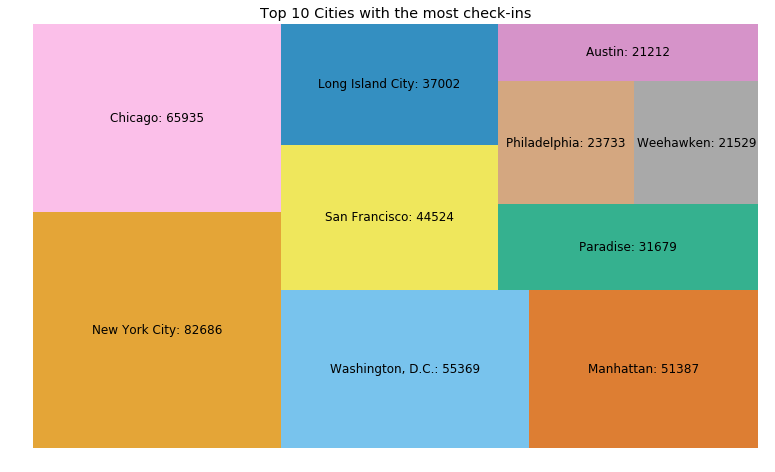

In [155]:
plt.style.use('ggplot')
scale=1.30
plt.rcParams['figure.figsize'] = (10.0*scale, 6.0*scale) 
group_df=df_city[["city", "total_city"]].drop_duplicates().sort_values("total_city", ascending=False).head(10)
labels = group_df.apply(lambda row: row.city + ": {}".format(row.total_city), axis=1)
 
n = group_df.shape[0]
color = sns.color_palette("colorblind", n)
np.random.shuffle(color)

squarify.plot(sizes=group_df.total_city, label=labels, alpha=.8, color=color, text_kwargs={'fontsize':12})
plt.title("Top 10 Cities with the most check-ins")
plt.axis('off')
plt.show()

In [7]:
df = df_poi[["poi_id", "category"]].merge(df_check, how='inner', on="poi_id")

In [57]:
tmp_df = df[["category", "poi_id"]].groupby("category").count().sort_values("poi_id", ascending=False).cumsum()/df.poi_id.count()

tmp_df = tmp_df.reset_index()
tmp_df.columns = ["category", "percent"]
tmp_df[tmp_df.percent>=0.95].head()

,category,percent
217,Cuban Restaurant,0.950181
218,Cemetery,0.950853
219,Design Studio,0.951523
220,Wine Shop,0.952185
221,Men's Store,0.952842
